# Battle of the Neighborhoods

#### Potential location for new sushi restaurant in Toronto


## 1.Introduction

As an international city, Toronto is greatly populated and open-minded. And Japanese food is one of the most well-known meal categories all over the world. Sushi is a traditional Japanese dish and always be treated as high-level cuisine, which stands for being healthy, aesthetical and cultural, becoming increasingly popular. Sushi restaurant could be a business with large profitable potential. However, running a restaurant depends on a lot of conditions and location is one of the keys for its success. 

The object of this project is to use Foursquare location data, getting venues distribution information. We aim to figure out the most ideal location for starting a sushi-restaurant business in Toronto, providing investors some useful suggestions.

## 2.Target Audience

This project is aimed towards investors or business owners who want to open a new sushi restaurant in Toronto. Our analysis would be a good reference and provide some fundamental information for our target audience.

## 3.Data Overview

Firstly, we grab information from Wikipedia website. The website is about of list of postal codes of Canada: M, and we scrape the list table, clean and organize and get the information of boroughs and neighborhoods of Toronto; We got according latitude and longitude information of each neighborhood from https://cocl.us/Geospatial_data. The neighborhood location information would be used to get venues information from foursquare website. Then, we kept only sushi information from foursquare and use them to calculate the condition of sushi restaurant in Toronto and make the final business recommendation and decision.



## 4. Methodology

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                       

### Grab data from wikipedia website

In [3]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source, 'lxml')
table = soup.find("table")
table_rows = table.tbody.find_all("tr")

### Clean data

In [4]:
res = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    
    # Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
    if row != [] and row[1] != "Not assigned\n":
        # If a cell has a borough but a "Not assigned" neighborhood, then the neighborhood will be the same as the borough.
        if "Not assigned" in row[2]: 
            row[2] = row[1]
        res.append(row)

In [5]:
df = pd.DataFrame(res, columns = ["PostalCode", "Borough", "Neighborhood"])
df.head()

,PostalCode,Borough,Neighborhood
0,M3A\n,North York\n,Parkwoods\n
1,M4A\n,North York\n,Victoria Village\n
2,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"
3,M6A\n,North York\n,"Lawrence Manor, Lawrence Heights\n"
4,M7A\n,Downtown Toronto\n,"Queen's Park, Ontario Provincial Government\n"


In [6]:
df['PostalCode'] = df['PostalCode'].str.replace("\n","")
df['Borough'] = df['Borough'].str.replace("\n","")
df['Neighborhood'] = df['Neighborhood'].str.replace("\n","")
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [7]:
print('shape:',df.shape)

shape: (103, 3)


### Get latitude and longitude coordinates information of neighborhood from https://cocl.us/Geospatial_data

In [8]:
Geospatial_data = pd.read_csv('https://cocl.us/Geospatial_data')
Geospatial_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge coordinates information with borough and neighborhoods dataframe based on postal code

In [9]:
geo_data = pd.merge(df, Geospatial_data, how='left', left_on='PostalCode', right_on='Postal Code')
geo_data = geo_data.drop('Postal Code', axis = 1)
geo_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Extract data of Toronto

In [10]:
df3 = geo_data[geo_data.Borough.str.contains('Toronto')].reset_index(drop=True)
df3.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


### Get geographical coordinates of Toronto

In [11]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Visualization of Toronto neighborhoods

In [12]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


for lat, lng, borough, neighborhood in zip(df3['Latitude'], df3['Longitude'], df3['Borough'], df3['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Utilizing the Foursquare API to explore the neighborhoods 

In [13]:
# @hidden_cell
CLIENT_ID = '100GZZZICD45CQV0L0TRGTN3KVQK33BFSDTLAPV4APUR0KR2' 
CLIENT_SECRET = '4JSBJWSGXGX2Q02WHUX132ZEDKOPGAS5GITDY40D22NGUXVK' 
VERSION = '20200701' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 100GZZZICD45CQV0L0TRGTN3KVQK33BFSDTLAPV4APUR0KR2
CLIENT_SECRET:4JSBJWSGXGX2Q02WHUX132ZEDKOPGAS5GITDY40D22NGUXVK


### Explore Neighborhoods in Toronto

#### Create a function to repeat the same process to all the neighborhoods in Toronto

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

####  write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [15]:
toronto_venues = getNearbyVenues(names=df3['Neighborhood'],
                                   latitudes=df3['Latitude'],
                                   longitudes=df3['Longitude']
                                  )



Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [16]:
print(toronto_venues.shape)
toronto_venues.head()

(1624, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park


### Analyze each neighborhood using one hot coding

In [17]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [18]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.017544,0.035088,0.000000,0.000000,0.00,0.017544,0.017544,0.000000,0.035088,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.087719,0.000000,0.000000,0.000000,0.00,0.000000,0.017544,0.000000,0.017544,0.000000,0.00,0.000000,0.000,0.017544,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.00,0.000000,0.000000,0.035088,0.000000,0.000000,0

### Neighborhood and the mean frequency of Sushi Restaurant

In [29]:
sushi_res_data = toronto_grouped[['Neighborhood']]
sushi_res_data.head()

,Neighborhood
0,Berczy Park
1,"Brockton, Parkdale Village, Exhibition Place"
2,"Business reply mail Processing Centre, South C..."
3,"CN Tower, King and Spadina, Railway Lands, Har..."
4,Central Bay Street


In [31]:
sushi_res_data['Sushi Restaurant']= toronto_grouped['Sushi Restaurant']
sushi_res_data.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Neighborhood,Sushi Restaurant
0,Berczy Park,0.017544
1,"Brockton, Parkdale Village, Exhibition Place",0.000000
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.014493


### k-means clustering

In [36]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  

In [69]:
X = sushi_res_data[['Sushi Restaurant']]
X.head()

,Sushi Restaurant
0,0.017544
1,0.000000
2,0.000000
3,0.000000
4,0.014493


### Building k-means clustering model and collecting distortions and inertias of model calculated by different k

In [39]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


### Distortion result 


In [40]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.024241343129268882
2 : 0.01635240395167885
3 : 0.008238383852776726
4 : 0.003078079463213855
5 : 0.002230497880338153
6 : 0.0013134849728302876
7 : 0.0007911504780853899
8 : 0.0006235620752028691
9 : 0.00047593588281998316


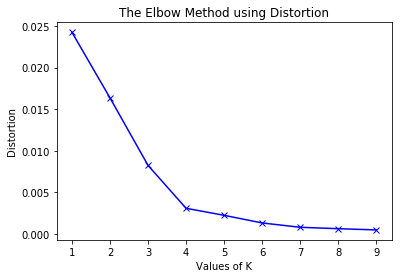

In [41]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

### Elbow point is k = 4

In [44]:
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(X)
labels = k_means.labels_

print(labels)

[3 1 1 1 3 1 0 1 0 1 1 3 2 1 1 1 0 1 1 1 1 1 1 3 1 3 1 1 0 1 3 1 1 0 1 1 3
 3 3]


### Assign labels to the according row


In [70]:
sushi_res_data["Labels"] = labels
sushi_res_data.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Neighborhood,Sushi Restaurant,Labels
0,Berczy Park,0.017544,3
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,1
2,"Business reply mail Processing Centre, South C...",0.000000,1
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,1
4,Central Bay Street,0.014493,3


In [46]:
df3.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


### Prepare neighborhood and label data for map visualization

In [47]:
sushi_neigh_loc = pd.merge(sushi_res_data, df3, how='left', left_on='Neighborhood', right_on='Neighborhood')
sushi_neigh_loc.head()

,Neighborhood,Sushi Restaurant,Labels,PostalCode,Borough,Latitude,Longitude
0,Berczy Park,0.017544,3,M5E,Downtown Toronto,43.644771,-79.373306
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,1,M6K,West Toronto,43.636847,-79.428191
2,"Business reply mail Processing Centre, South C...",0.000000,1,M7Y,East Toronto,43.662744,-79.321558
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,1,M5V,Downtown Toronto,43.628947,-79.394420
4,Central Bay Street,0.014493,3,M5G,Downtown Toronto,43.657952,-79.387383


In [49]:
sushi_neigh_loc = sushi_neigh_loc.drop(['PostalCode', 'Borough'], axis = 1)

In [54]:
sushi_neigh_loc.head()

,Neighborhood,Sushi Restaurant,Labels,Latitude,Longitude
0,Berczy Park,0.017544,3,43.644771,-79.373306
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,1,43.636847,-79.428191
2,"Business reply mail Processing Centre, South C...",0.000000,1,43.662744,-79.321558
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,1,43.628947,-79.394420
4,Central Bay Street,0.014493,3,43.657952,-79.387383


### Cluster visualization

In [61]:
# create map
map_sushi = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neigh, lab in zip(sushi_neigh_loc['Latitude'], sushi_neigh_loc['Longitude'], sushi_neigh_loc['Neighborhood'], sushi_neigh_loc['Labels']):
    label = folium.Popup(str(neigh) + ' cluster ' + str(lab), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[lab],
        fill=True,
        fill_color=rainbow[lab],
        fill_opacity=0.7).add_to(map_sushi)
       
map_sushi

In [57]:
rainbow

['#8000ff', '#2adddd', '#d4dd80', '#ff0000']

### Cluster 1 --Purple
### Cluster 2 --Bright cyan
### Cluster 3 --Yellow-green
### Cluster 4 --Red

## 5.Results

### Cluster 1

In [72]:
cluster1 = sushi_neigh_loc.loc[sushi_neigh_loc['Labels'] == 0]
cluster1

,Neighborhood,Sushi Restaurant,Labels,Latitude,Longitude
6,Church and Wellesley,0.054054,0,43.665860,-79.383160
8,Davisville,0.058824,0,43.704324,-79.388790
16,"India Bazaar, The Beaches West",0.055556,0,43.668999,-79.315572
28,"Runnymede, Swansea",0.085714,0,43.651571,-79.484450
33,"Summerhill West, Rathnelly, South Hill, Forest...",0.062500,0,43.686412,-79.400049


There are 5 neighborhoods belongs to cluster 1. Based on the average frequency of sushi restaurant occurrence, cluster 1 can be defined as neighborhood cluster with high frequency sushi-restaurant occurrence, which is between 0.05-0.09. This data results indicates that the neighborhood assigned in cluster 1 are the neighborhood where sushi restaurants are densely distributed. 

### Cluster 2

In [74]:
cluster2 = sushi_neigh_loc.loc[sushi_neigh_loc['Labels'] == 1]
cluster2

,Neighborhood,Sushi Restaurant,Labels,Latitude,Longitude
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,1,43.636847,-79.428191
2,"Business reply mail Processing Centre, South C...",0.000000,1,43.662744,-79.321558
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,1,43.628947,-79.394420
5,Christie,0.000000,1,43.669542,-79.422564
7,"Commerce Court, Victoria Hotel",0.000000,1,43.648198,-79.379817
9,Davisville North,0.000000,1,43.712751,-79.390197
10,"Dufferin, Dovercourt Village",0.000000,1,43.669005,-79.442259
13,"Garden District, Ryerson",0.000000,1,43.657162,-79.378937
14,"Harbourfront East, Union Station, Toronto Islands",0.010000,1,43.640816,-79.381752
15,"High Park, The Junction South",0.000000,1,43.661608,-79.464763


There are 24 neighborhoods assigned in cluster 2, and from the result of the average frequency of sushi restaurant occurrence, which showed 23 neighborhoods has value 0.0 and only 1 neighborhood has value around 0.01. The average frequency of sushi restaurant value in this cluster indicates that the neighborhoods assigned in clusters has almost 0 sushi restaurant in their area. The distribution of the sushi restaurant is extremely sparsely. 

### Cluster 3

In [76]:
cluster3 = sushi_neigh_loc.loc[sushi_neigh_loc['Labels'] == 2]
cluster3

,Neighborhood,Sushi Restaurant,Labels,Latitude,Longitude
12,"Forest Hill North & West, Forest Hill Road Park",0.25,2,43.696948,-79.411307


Cluster 3 has only 1 neighborhood included, which the value of average frequency of sushi restaurant occurrence is highest among the four clusters. The value is 0.25, much higher than any of the value of neighborhood in the other three cluster.

### Cluster 4

In [77]:
cluster4 = sushi_neigh_loc.loc[sushi_neigh_loc['Labels'] == 3]
cluster4

,Neighborhood,Sushi Restaurant,Labels,Latitude,Longitude
0,Berczy Park,0.017544,3,43.644771,-79.373306
4,Central Bay Street,0.014493,3,43.657952,-79.387383
11,"First Canadian Place, Underground city",0.020000,3,43.648429,-79.382280
23,"Queen's Park, Ontario Provincial Government",0.033333,3,43.662301,-79.389494
25,"Richmond, Adelaide, King",0.021053,3,43.650571,-79.384568
30,"St. James Town, Cabbagetown",0.021277,3,43.667967,-79.367675
36,"The Danforth West, Riverdale",0.023810,3,43.679557,-79.352188
37,"Toronto Dominion Centre, Design Exchange",0.020000,3,43.647177,-79.381576
38,"University of Toronto, Harbord",0.028571,3,43.662696,-79.400049


The cluster 4 includes 9 neighborhoods. The mean frequency of the sushi restaurant is around 0.1-0.4, which means the value is in a middle level according to other three clusters information. This indicates that the neighborhoods assigned in cluster 4, their sushi restaurant distribution is not dense or sparse. 

## 6.Discussion

According to the results, it is obvious that the distribution of sushi restaurant in different neighborhood has different feature. The feature could be separated into four clusters. Very few(sparsely), middle level (not dense nor sparse), densely distributed, very densely distributed. We noted that the neighborhoods which the sushi restaurants are densely distributed (cluster 1) and extremely densely distributed (cluster 3), have a smaller number of neighborhoods, which is 5 and 1, respectively. In contrast, the number of neighborhoods which the sushi restaurants are sparsely distributed (cluster 1) are great – 24, which indicates that there are a lot of neighborhoods which do not have a sushi restaurant or need more sushi restaurant. There are a great number of neighborhoods which have a potential need on sushi restaurant in another word. In addition, there are 9 neighborhoods which the mean frequency of sushi restaurant occurrence is middle level, which means these neighborhoods have a distribution of sushi restaurant which is not sparse nor dense. 

The data we used for analyzing only including sushi restaurant. There are still a great many of information to be consider for a new sushi restaurant business, such as population of the neighborhood, age group, culture, education, income, etc. As our present result, the neighborhood assigned in cluster 2 has an extreme sparsely sushi restaurant distribution, and they are more recommended to be ideal location to start a sushi restaurant business for lack of competition. Also, the neighborhoods assigned in cluster 4 can be the second recommendation for a sushi restaurant business, for there maybe have more demand for sushi restaurants. It is because firstly, the neighborhoods in cluster 2, they already have some sushi restaurants in there, which means people living in these areas have interest and demand for this kind of restaurant. In the same time, the distribution of this kind of restaurant is not very dense at this time, so it is supposed to be not much competition. More research needed to be processed to refine our results. 


## 7.Conclusion

In the study, we collected data of neighborhood in Toronto, their geographical location, venues information from Foursquare API. We cleaned the data use k-means clustering machine learning method to cluster the average frequency of occurrence of sushi restaurant in each neighborhood, in order to figure out the distribution of sushi restaurant in each neighborhood. Based on the result, we found the neighborhoods which has less density of sushi restaurant distribution which is more suitable for a new sushi restaurant business in Toronto. The analysis method can be used in a more extensive range, such as starting a Italian restaurant business, or even open a new grocery store, etc. This study can be an instruction for people to tackle with business location problem or explore for more complex realistic ideas. 